We find the minimal outer ellipsoid covering a given set of points through a convex optimization.

In [3]:
import jupyter_black

jupyter_black.load()
import numpy as np
import matplotlib.pyplot as plt
import pydrake.solvers as solvers
import pydrake.symbolic as sym
import minimal_outer_ellipsoid.ellipsoid as ellipsoid


First generate some random points to be covered. These points lie near the surface of an ellipsoid.

In [9]:
num_pts = 200
sphere_pts = np.random.randn(num_pts, 3)
sphere_pts /= np.sqrt(np.sum(sphere_pts**2, axis=1, keepdims=True))
pts = (
    np.array([[1, 2, 3], [2, -4, 3], [0, 1, -4]]) @ sphere_pts.T
    + np.array([[1, 3, 4]]).T
).T
pts += 0.05 * np.random.randn(num_pts, 3)

In [10]:
prog = solvers.MathematicalProgram()
S = prog.NewSymmetricContinuousVariables(3, "S")
b = prog.NewContinuousVariables(3, "b")
c = prog.NewContinuousVariables(1, "c")[0]

ellipsoid.add_pts_in_ellipsoid_constraint(prog, pts, S, b, c)
ellipsoid.add_minimize_volume_cost(prog, S, b, c)

result = solvers.Solve(prog)

assert result.is_success()
S_sol = result.GetSolution(S)
b_sol = result.GetSolution(b)
c_sol = result.GetSolution(c)

AttributeError: PathCollection.set() got an unexpected keyword argument 'marker_size'

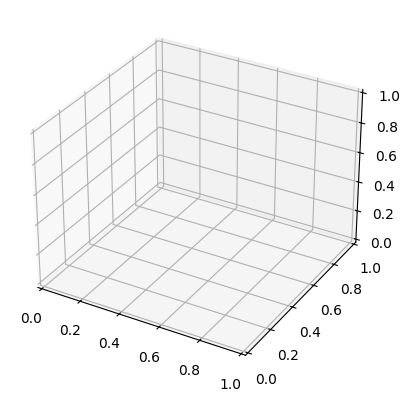

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=np.full_like((num_pts,), 0.1))

# Now plot the ellipsoid.
A, d = ellipsoid.to_affine_ball(S_sol, b_sol, c_sol)

U, V = np.meshgrid(np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50))
X_sphere = np.cos(U) * np.sin(V)
Y_sphere = np.sin(U) * np.sin(V)
Z_sphere = np.cos(V)
XYZ_ellipsoid = A @ (
    np.concatenate(
        (
            X_sphere.reshape((1, -1)),
            Y_sphere.reshape((1, -1)),
            Z_sphere.reshape((1, -1)),
        ),
        axis=0,
    )
    + d.reshape((-1, 1))
)
X_ellipsoid = XYZ_ellipsoid[0, :].reshape(X_sphere.shape)
Y_ellipsoid = XYZ_ellipsoid[1, :].reshape(X_sphere.shape)
Z_ellipsoid = XYZ_ellipsoid[2, :].reshape(X_sphere.shape)
h_ellipsoid = ax.plot_surface(
    X_ellipsoid, Y_ellipsoid, Z_ellipsoid, color=[0, 1, 0, 0.2]
)
ax.axis("equal")
fig.show()